# General Algorithm For Course (version 0.2)
1. Remove essential nodes and clean up network
2. Perform Markov Cluster Algorithm (MCL) setting numnodes in the nieghbourhood of 200/300. 
3. Create new network, where each node represents the clusters:
  - Weighted network option with weights set to number of connections between cluster a and cluster b
  - Unweighted set by direct connection.
4. Perform centrality analysis on the cluster network and identify important clusters.
5. Find shortest path nodes for important clusters as proteins of inteerest.

In [1]:
import networkx as nx
import markov_clustering as mc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import func
from pprint import pprint

In [2]:
# These are the essential proteins that the biochemist have identified 
# https://docs.google.com/document/d/12kaAjgjEsQtCOaRqw6g2ZNeLzN-rlzmLaGApKCdI1uc/edit 
# E3 protein is LPD1
names = ['LPD1', 'PDA1', 'PYC2', 'PDB1', 'PTC1', 'BAT2', 'KGD1', 'AIM22', 'PKP1', 'PTC5', 'LAT1']

important_nodes = func.parser(names)
pprint(important_nodes)

{'AIM22': '4932.YJL046W',
 'BAT2': '4932.YJR148W',
 'KGD1': '4932.YIL125W',
 'LAT1': '4932.YNL071W',
 'LPD1': '4932.YFL018C',
 'PDA1': '4932.YER178W',
 'PDB1': '4932.YBR221C',
 'PKP1': '4932.YIL042C',
 'PTC1': '4932.YDL006W',
 'PTC5': '4932.YOR090C',
 'PYC2': '4932.YBR218C'}


In [3]:
# Creates the network and removes initial nodes 
network_name = "network_info/4932_protein_links_v11_5.txt"
G = func.remove_threshold(network_name, 700)

essential_proteins = "network_info/essential_proteins.csv"
G = func.remove_essential(G, essential_proteins)

print(G)

Graph with 5098 nodes and 73277 edges


In [4]:
#Finds clusters

# Here we are going to lose the protein names as the matrix gets assigned to their index. 
# So we recover that with a hash table (dictionary)
adj_matrix = nx.adjacency_matrix(G) 

# Create a hash table that takes takes a number and returns a protein name
protein_hash = {}
for index, node in enumerate(G.nodes):
    protein_hash[index] = node

/var/folders/qm/5krpz0vd1n5g2tknvt69wkx00000gn/T/ipykernel_19392/645912874.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


In [5]:
#Runs MCL 

# expansion parameter and inflation parameter tuned
# result = mc.run_mcl(adj_matrix, expansion = 2, inflation = 1.04)  

# run with default parameters    
result = mc.run_mcl(adj_matrix)         
clusters = mc.get_clusters(result) 
# print(clusters) # this will be a tuple of numbers
# print(G.nodes) # this is a list of all nodes as 4xxx

In [6]:
# finds how many clusters there are

# When running 
# E = 2, I = 2  --> Number of Cluster = 1050
#               --> Nodes = 5098

# E = 10, I = 2 --> Number of Clusters = 469
#               --> Nodes = 5098
# print(type(clusters))
# print(type(clusters[0]))
# print(type(clusters[0][0]))


num_clusters = len(clusters)
print(f"The number of clusters {num_clusters}") 

# finds the total number of nodes from the MCL
counter = 0
for cluster in clusters:
    counter += len(cluster)
print(f"The total number of nodes {counter}") 

# The average cluster size
print(f"The average cluster size is {counter/num_clusters}")

The number of clusters 1001
The total number of nodes 5098
The average cluster size is 5.092907092907093


In [7]:
# Renaming proteins in the clusters
# print(clusters) # list of tuples
named_clusters = func.renaming_clusters(clusters, protein_hash)
print(len(named_clusters)) #check that no clusters were lost
# print(named_clusters) #this here has the names as 4xxx 

1001


Graph with 1001 nodes and 8700 edges


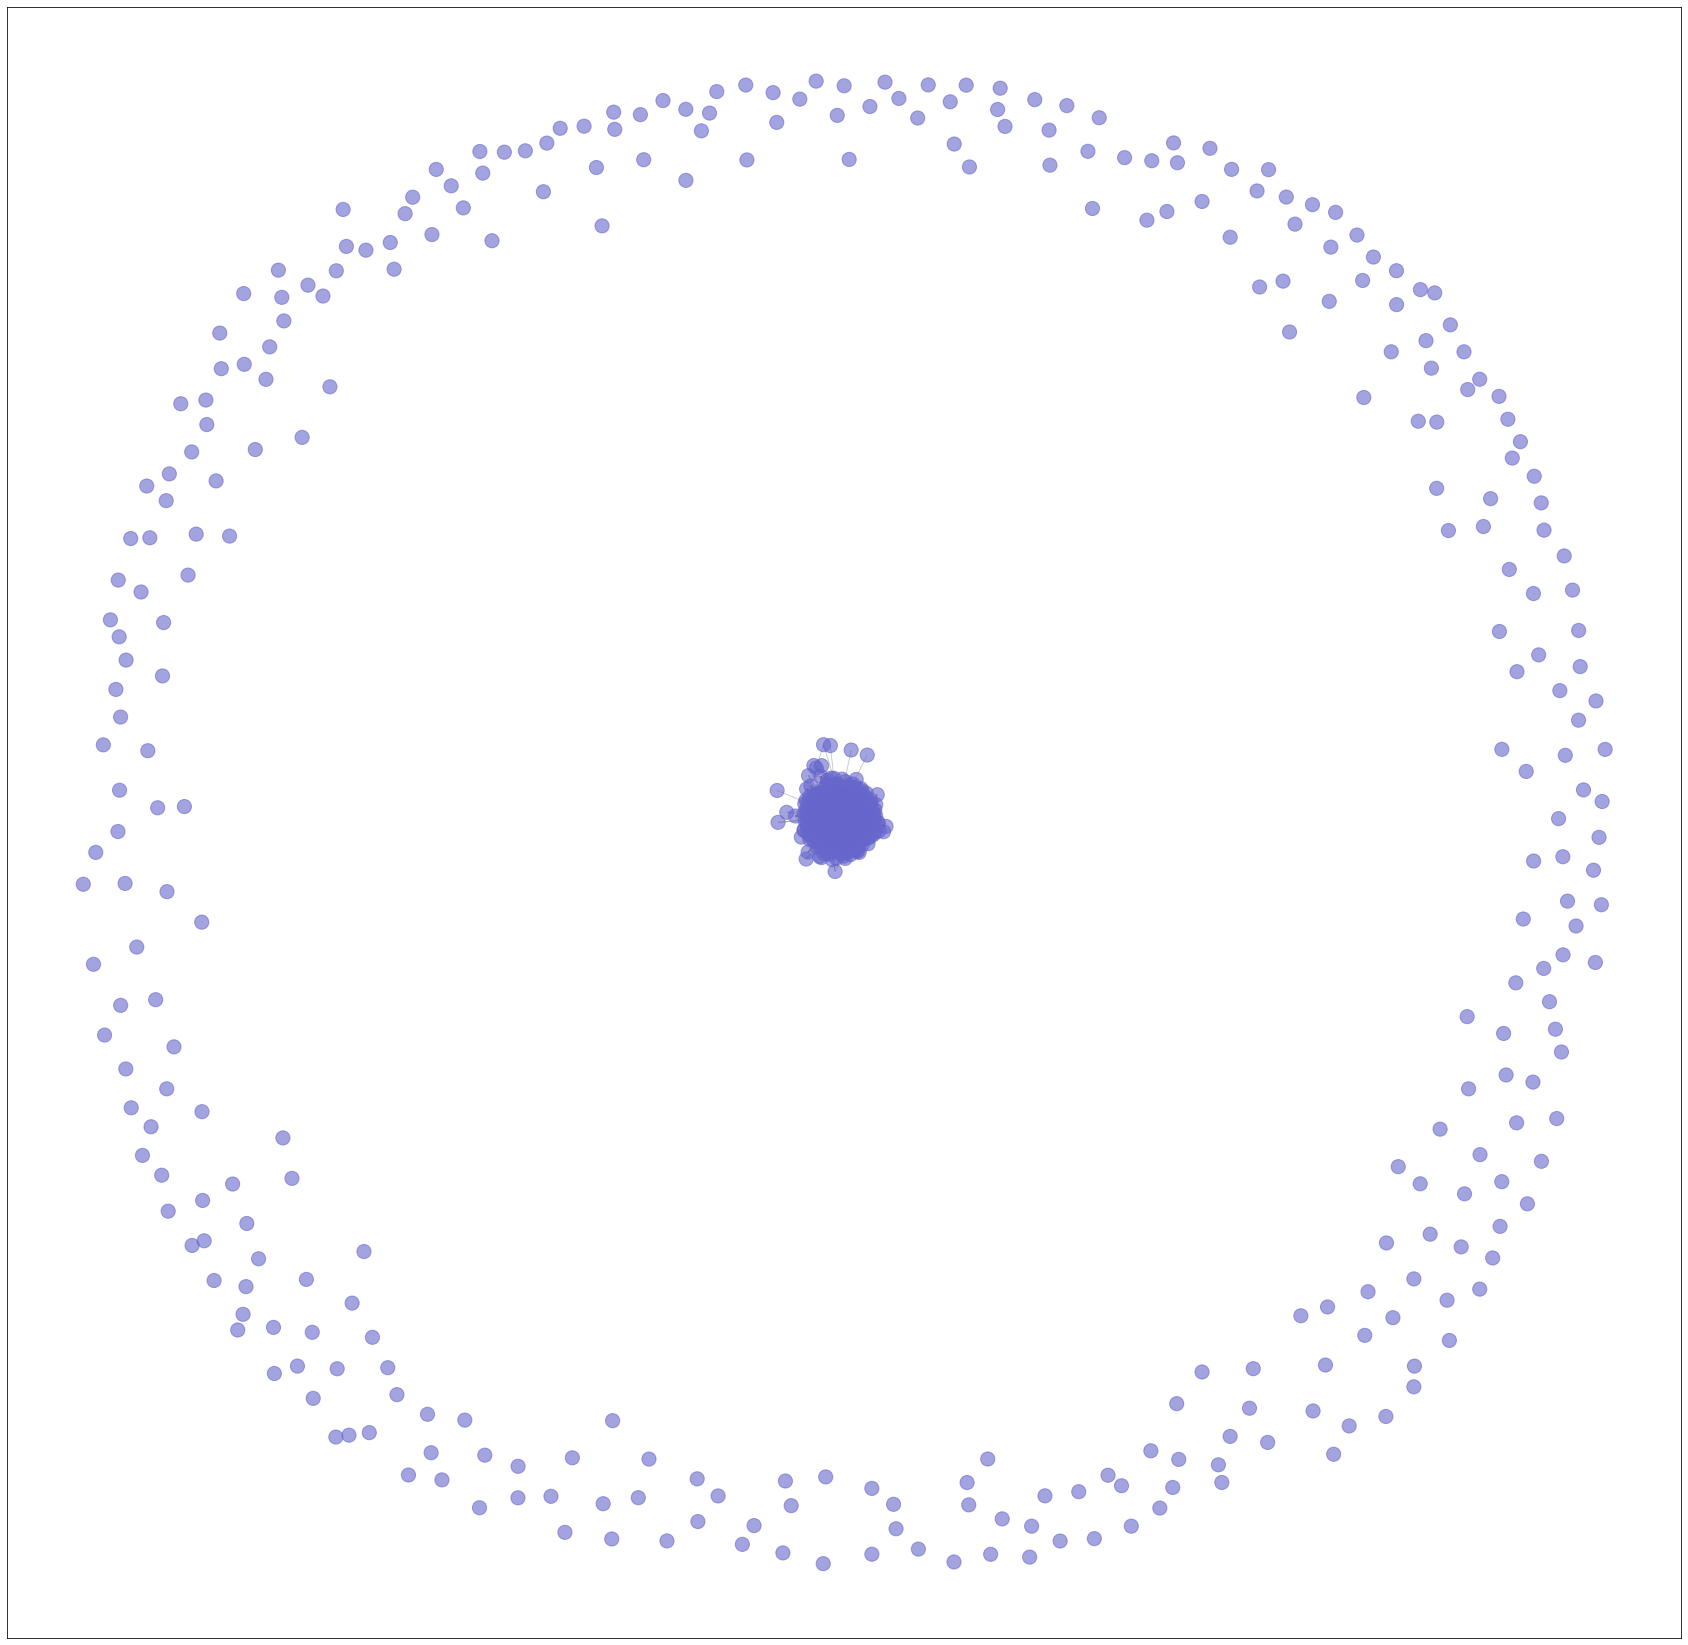

In [8]:
weighted_network = func.convert_to_weighted(G, named_clusters)
print(weighted_network)
func.pretty_draw(weighted_network)

In [9]:
'''
#Finds positions of nodes
pos = nx.spring_layout(weighted_network)

# plots it
nx.draw(weighted_network, pos, with_labels = True)
labels = nx.get_edge_attributes(G,'weight')

#adds the edges in
nx.draw_networkx_edge_labels(weighted_network, pos, edge_labels=labels)
'''

"\n#Finds positions of nodes\npos = nx.spring_layout(weighted_network)\n\n# plots it\nnx.draw(weighted_network, pos, with_labels = True)\nlabels = nx.get_edge_attributes(G,'weight')\n\n#adds the edges in\nnx.draw_networkx_edge_labels(weighted_network, pos, edge_labels=labels)\n"

In [10]:
mapping = {node : f"w{node}" for node in weighted_network.nodes}
weighted_network_rename = nx.relabel_nodes(weighted_network, mapping)
pprint(weighted_network_rename.nodes)


NodeView(('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25', 'w26', 'w27', 'w28', 'w29', 'w30', 'w31', 'w32', 'w33', 'w34', 'w35', 'w36', 'w37', 'w38', 'w39', 'w40', 'w41', 'w42', 'w43', 'w44', 'w45', 'w46', 'w47', 'w48', 'w49', 'w50', 'w51', 'w52', 'w53', 'w54', 'w55', 'w56', 'w57', 'w58', 'w59', 'w60', 'w61', 'w62', 'w63', 'w64', 'w65', 'w66', 'w67', 'w68', 'w69', 'w70', 'w71', 'w72', 'w73', 'w74', 'w75', 'w76', 'w77', 'w78', 'w79', 'w80', 'w81', 'w82', 'w83', 'w84', 'w85', 'w86', 'w87', 'w88', 'w89', 'w90', 'w91', 'w92', 'w93', 'w94', 'w95', 'w96', 'w97', 'w98', 'w99', 'w100', 'w101', 'w102', 'w103', 'w104', 'w105', 'w106', 'w107', 'w108', 'w109', 'w110', 'w111', 'w112', 'w113', 'w114', 'w115', 'w116', 'w117', 'w118', 'w119', 'w120', 'w121', 'w122', 'w123', 'w124', 'w125', 'w126', 'w127', 'w128', 'w129', 'w130', 'w131', 'w132', 'w133', 'w134', 'w135', 'w136', 'w13

In [11]:
# finds cluster that the LPD1 or E3 protein is in
# Very interesting, alot of the proteins are int he same cluster
for key, value in important_nodes.items():
    print(func.find_cluster(value, named_clusters), key)

36 LPD1
36 PDA1
36 PYC2
36 PDB1
151 PTC1
21 BAT2
36 KGD1
6 AIM22
150 PKP1
455 PTC5
36 LAT1


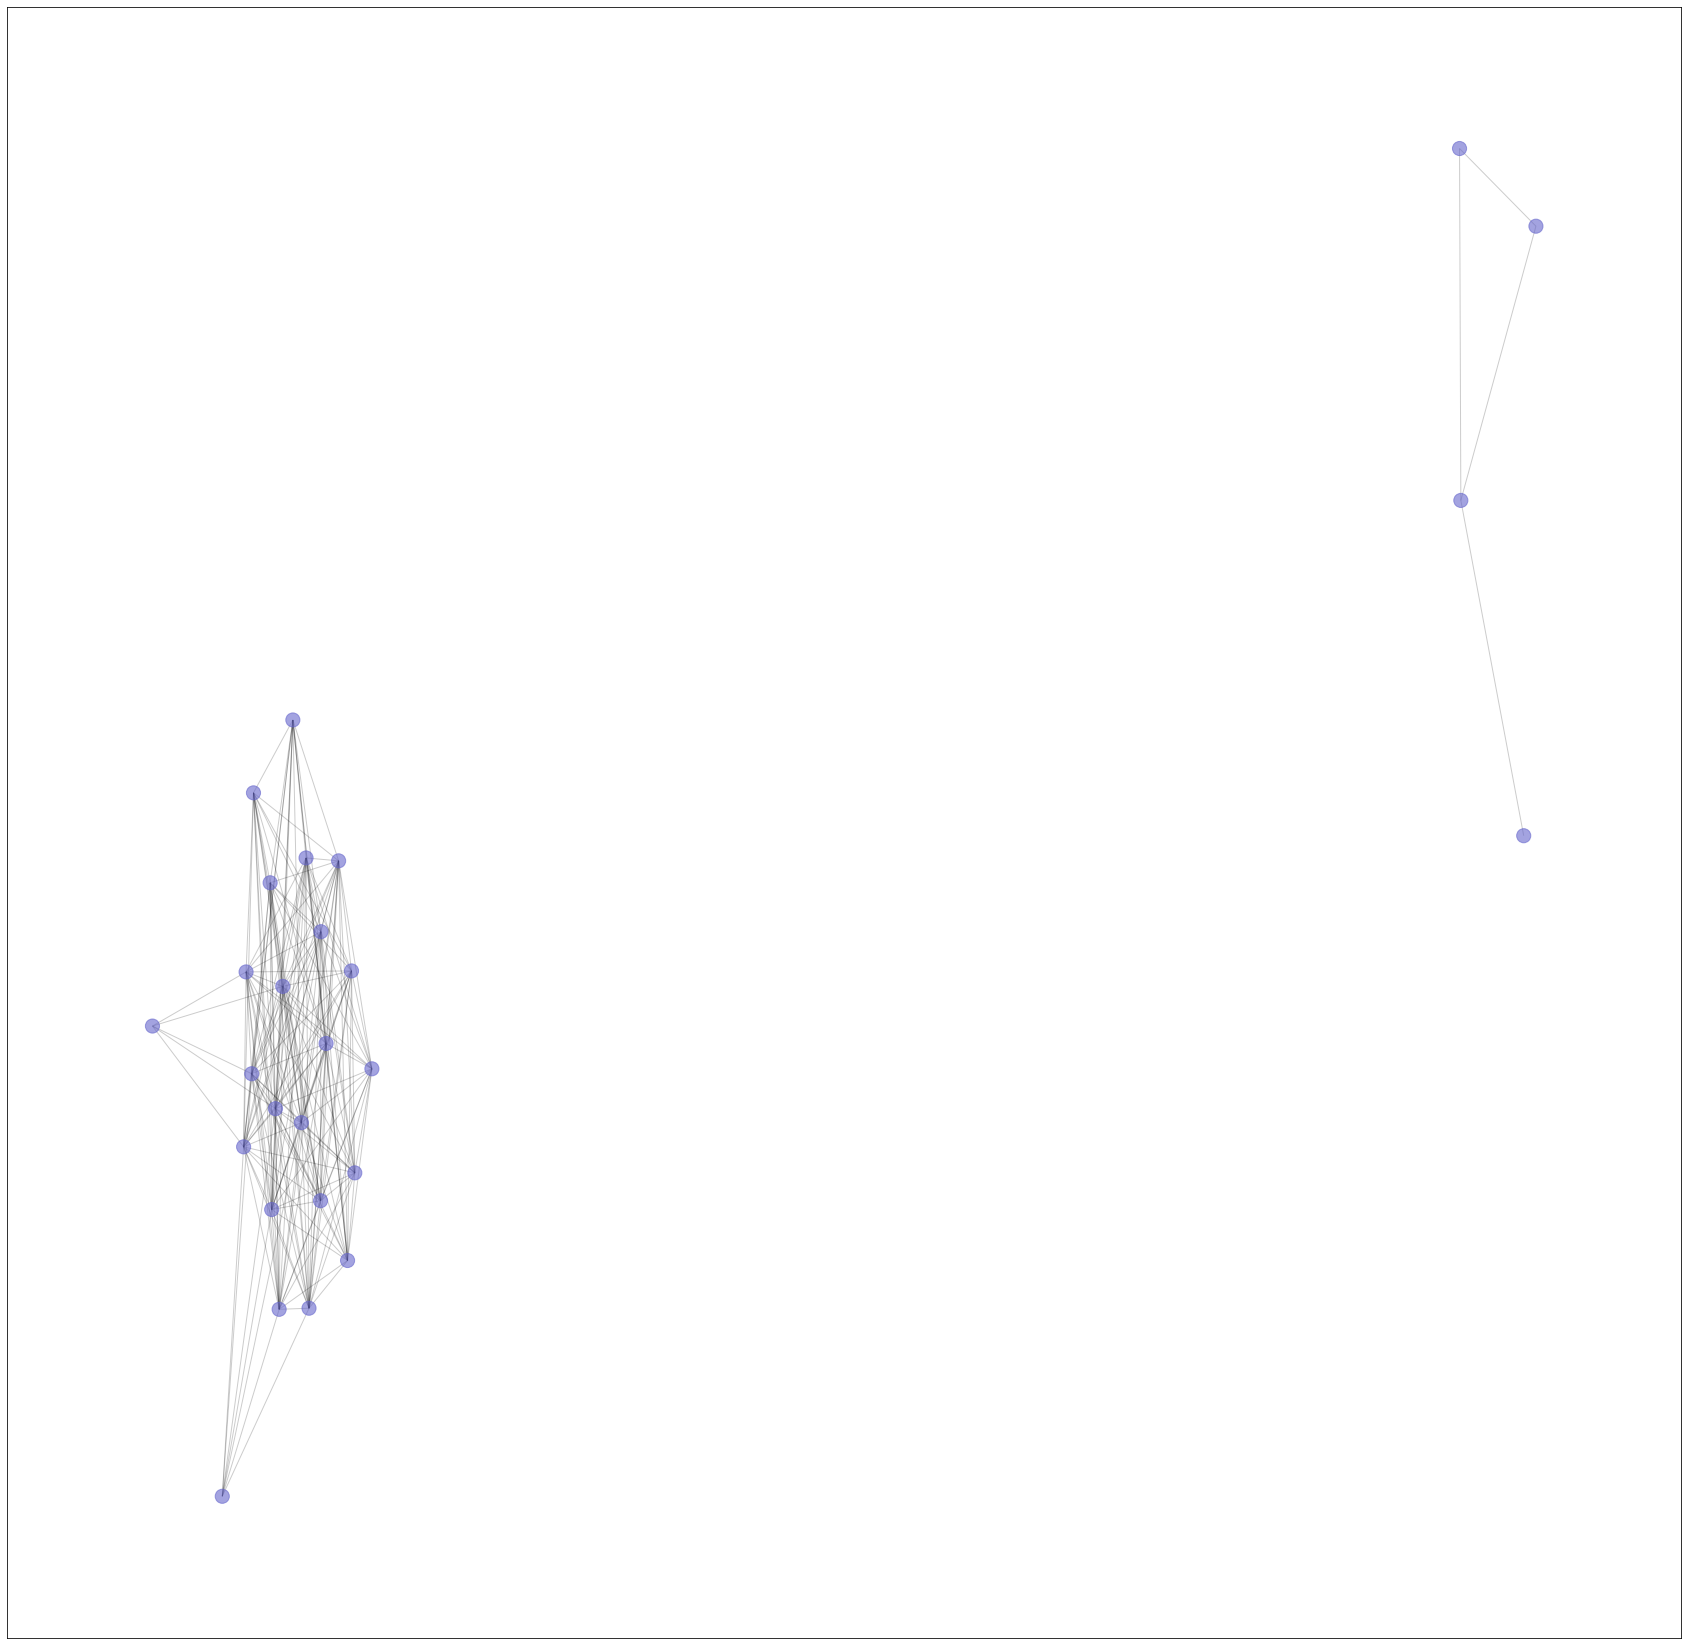

In [12]:
#Make a graph with only nodes in a certain cluster 
#cluster number 32 in this case as it has LPD1
cluster_network = func.cluster_graph(G, named_clusters[32], named_clusters[93])
func.pretty_draw(cluster_network)

In [13]:
b_centrality = func.between_centrality(G, named_clusters[32], named_clusters[93])

NetworkXNoPath: Target 4932.YDL121C cannot be reached from given sources

In [ ]:
# This is comparing cluster 32 and 93

# sorts the dictionary such that highest centrality is first
sorted_betweeness = dict(sorted(b_centrality.items(), key = lambda x: -x[1]))

# for key, val in sorted_betweeness.items():
#     print(f"The node {key} has a betweenness centrality score of {val}")

# gives first 5 maybe or more to BCMB students
prefered_names = func.parser(sorted_betweeness.keys(), False)
pprint(prefered_names)


{'4932.YAL054C': 'ACS1',
 '4932.YBL015W': 'ACH1',
 '4932.YBR006W': 'UGA2',
 '4932.YBR166C': 'TYR1',
 '4932.YBR218C': 'PYC2',
 '4932.YBR221C': 'PDB1',
 '4932.YBR248C': 'HIS7',
 '4932.YBR249C': 'ARO4',
 '4932.YCL009C': 'ILV6',
 '4932.YCL030C': 'HIS4',
 '4932.YCR005C': 'CIT2',
 '4932.YCR053W': 'THR4',
 '4932.YDL066W': 'IDP1',
 '4932.YDL078C': 'MDH3',
 '4932.YDR035W': 'ARO3',
 '4932.YDR127W': 'ARO1',
 '4932.YDR148C': 'KGD2',
 '4932.YDR158W': 'HOM2',
 '4932.YDR354W': 'TRP4',
 '4932.YDR380W': 'ARO10',
 '4932.YER052C': 'HOM3',
 '4932.YER055C': 'HIS1',
 '4932.YER065C': 'ICL1',
 '4932.YER090W': 'TRP2',
 '4932.YER178W': 'PDA1',
 '4932.YFL018C': 'LPD1',
 '4932.YGL009C': 'LEU1',
 '4932.YGL026C': 'TRP5',
 '4932.YGL062W': 'PYC1',
 '4932.YGL148W': 'ARO2',
 '4932.YGL202W': 'ARO8',
 '4932.YGR193C': 'PDX1',
 '4932.YGR208W': 'SER2',
 '4932.YHR137W': 'ARO9',
 '4932.YHR208W': 'BAT1',
 '4932.YIL020C': 'HIS6',
 '4932.YIL094C': 'LYS12',
 '4932.YIL116W': 'HIS5',
 '4932.YIL125W': 'KGD1',
 '4932.YJL200C': 'ACO2'

In [ ]:
# this here is just within cluster 32

c32 = nx.betweenness_centrality(func.cluster_graph(G, named_clusters[32]))
# print(c32)

In [ ]:
# sorts the dictionary such that highest centrality is first
c32_sorted = dict(sorted(c32.items(), key = lambda x: -x[1]))

# for key, val in sorted_betweeness.items():
#     print(f"The node {key} has a betweenness centrality score of {val}")

# gives first 5 maybe or more to BCMB students
c32_sorted = func.parser(c32_sorted.keys(), False)
pprint(c32_sorted)
print(len(c32_sorted))

{'4932.YAL054C': 'ACS1',
 '4932.YBL015W': 'ACH1',
 '4932.YBR006W': 'UGA2',
 '4932.YBR218C': 'PYC2',
 '4932.YBR221C': 'PDB1',
 '4932.YCR005C': 'CIT2',
 '4932.YDL066W': 'IDP1',
 '4932.YDL078C': 'MDH3',
 '4932.YDR148C': 'KGD2',
 '4932.YER065C': 'ICL1',
 '4932.YER178W': 'PDA1',
 '4932.YFL018C': 'LPD1',
 '4932.YGL062W': 'PYC1',
 '4932.YGR193C': 'PDX1',
 '4932.YIL125W': 'KGD1',
 '4932.YJL200C': 'ACO2',
 '4932.YKL029C': 'MAE1',
 '4932.YKL085W': 'MDH1',
 '4932.YKR097W': 'PCK1',
 '4932.YLR174W': 'IDP2',
 '4932.YLR304C': 'ACO1',
 '4932.YNL009W': 'IDP3',
 '4932.YNL037C': 'IDH1',
 '4932.YNL071W': 'LAT1',
 '4932.YNL117W': 'MLS1',
 '4932.YNR001C': 'CIT1',
 '4932.YOL126C': 'MDH2',
 '4932.YOR136W': 'IDH2',
 '4932.YOR142W': 'LSC1',
 '4932.YOR388C': 'FDH1',
 '4932.YPL262W': 'FUM1',
 '4932.YPR001W': 'CIT3',
 '4932.YPR006C': 'ICL2'}
33


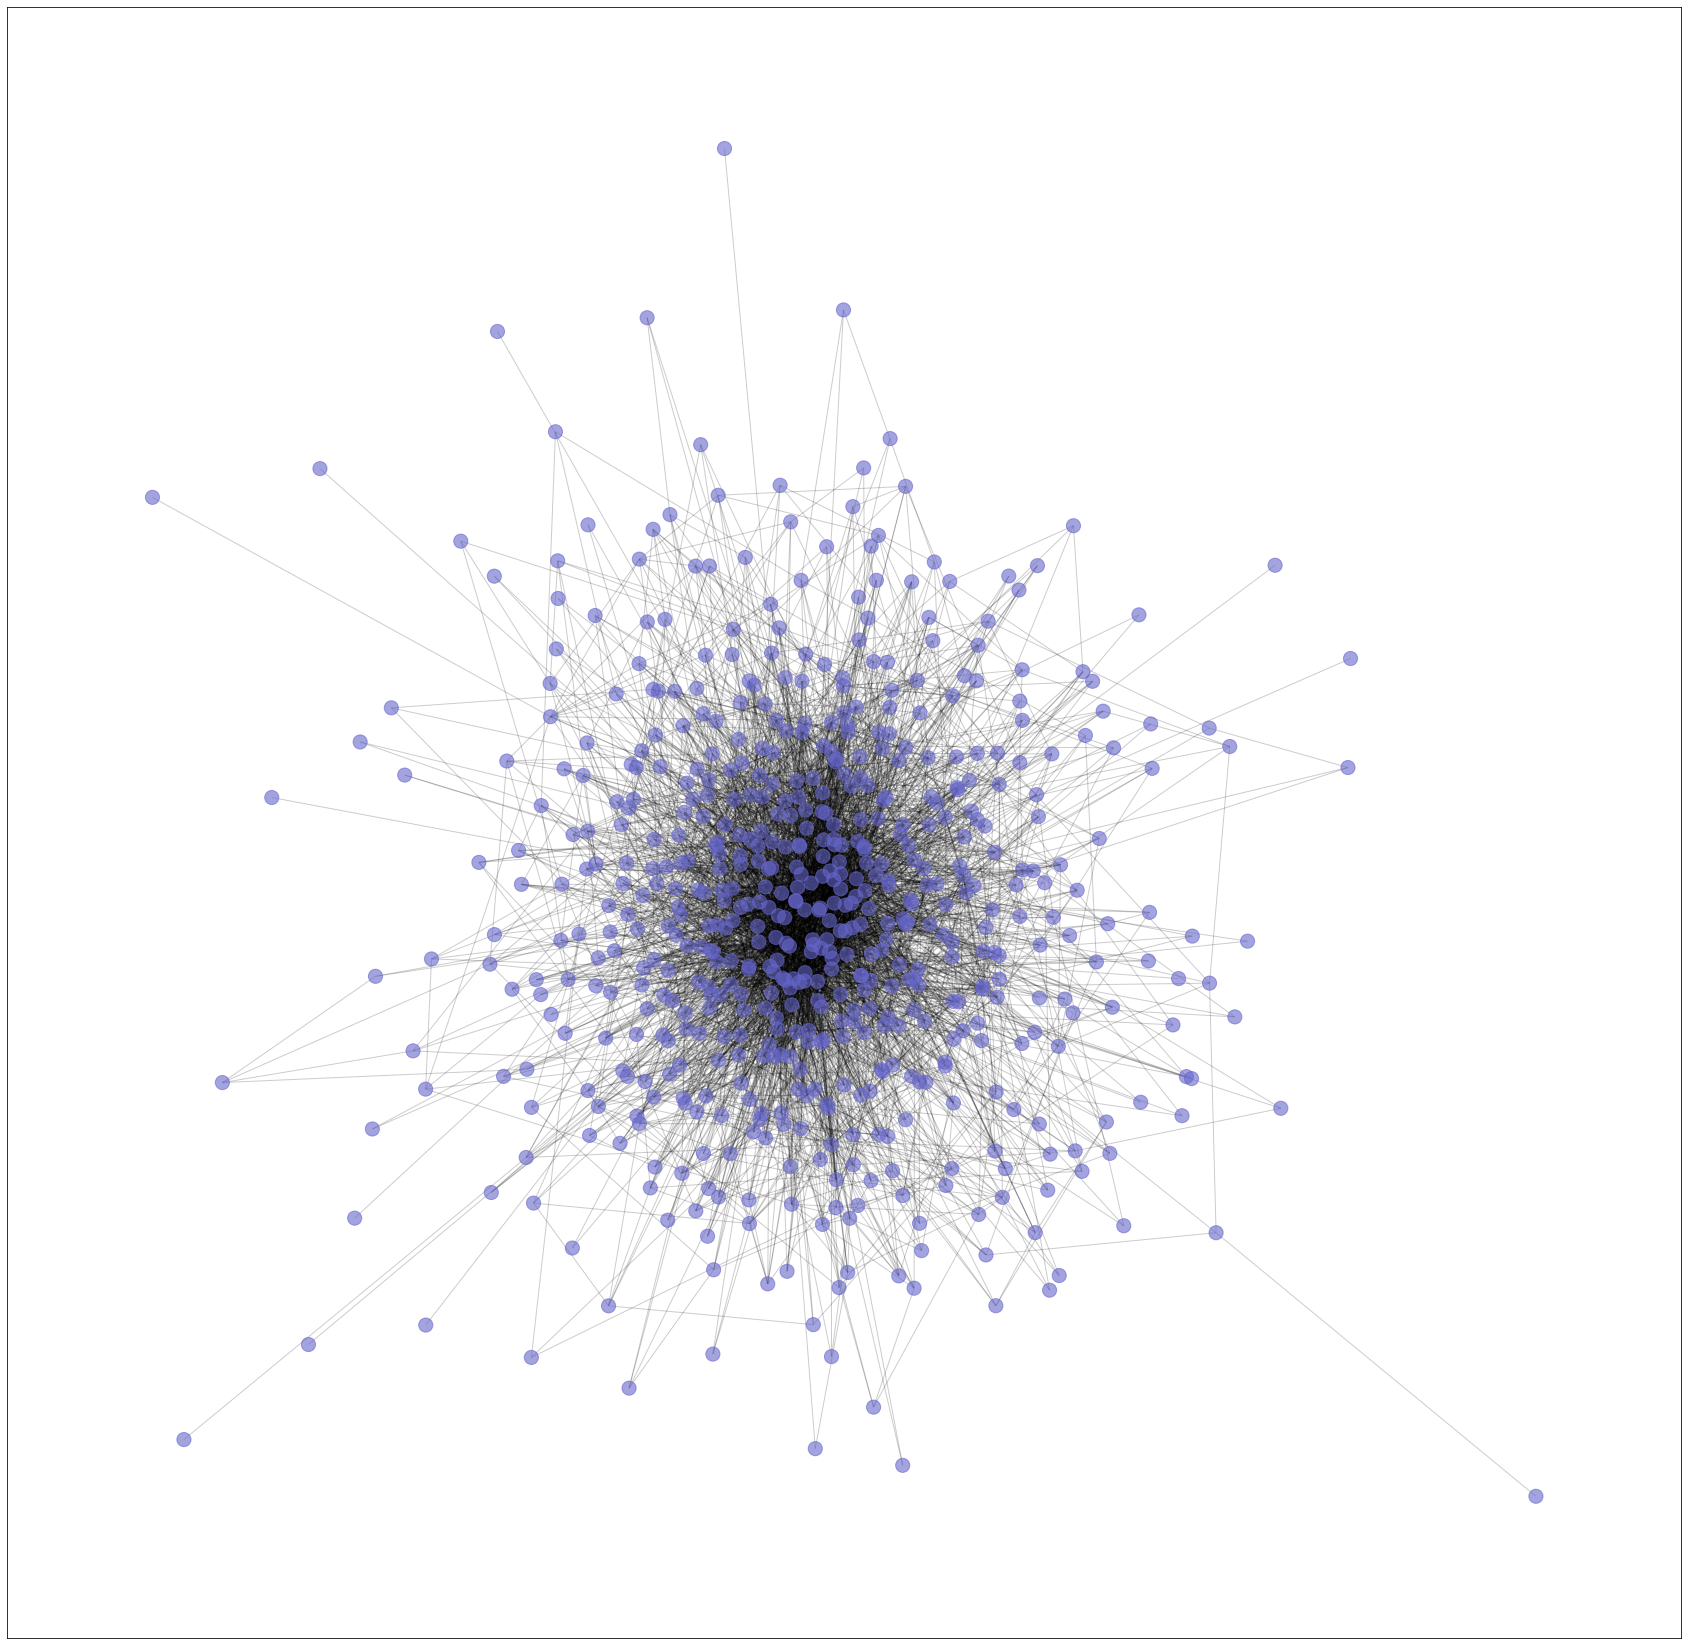

Graph with 615 nodes and 5305 edges


In [ ]:
# Iscolated the middle section of the graph as seen in an earlier picture
# Used clsuter 32 as the source as it contains LPD1 

filtered_weight = func.connected_clusters(weighted_network_rename, 'w32')
func.pretty_draw(filtered_weight)
print(filtered_weight)


In [ ]:
print(nx.number_connected_components(weighted_network))

436


In [ ]:
weighted_centrality = func.weighted_centrality(filtered_weight, 'w32')
# print(filtered_weight)
# print(named_clusters[32])
pprint(weighted_centrality)


OrderedDict([('w108', 0.09747992245915259),
             ('w3', 0.08584879534754916),
             ('w23', 0.07172528385488784),
             ('w259', 0.06590972029908612),
             ('w122', 0.06507892550540016),
             ('w305', 0.0642481307117142),
             ('w21', 0.06037108834117973),
             ('w339', 0.05510938798116865),
             ('w217', 0.050401550816948214),
             ('w167', 0.046801440044309056),
             ('w140', 0.046247576848518414),
             ('w5', 0.04569371365272778),
             ('w418', 0.04292439767377458),
             ('w285', 0.042647466075879256),
             ('w99', 0.040155081694821376),
             ('w46', 0.03821656050955414),
             ('w28', 0.0376626973137635),
             ('w9', 0.03267792855164774),
             ('w534', 0.03267792855164774),
             ('w123', 0.0321240653558571),
             ('w97', 0.028247022985322626),
             ('w175', 0.027416228191636666),
             ('w591', 0.0271392965937413